## __文本解码原理\-\-以MindNLP为例__

### 回顾：自回归语言模型

__根据前文预测下一个单词__
<div align=center><img src="./images/example.png"></div>

__一个文本序列的概率分布可以分解为每个词基于其上文的条件概率的乘积__
<div align=center><img src="./images/P%e5%85%ac%e5%bc%8f.png"></div>

* 𝑊_0:初始上下文单词序列
* 𝑇: 时间步
* 当生成EOS标签时，停止生成。

__MindNLP/huggingface Transformers提供的文本生成方法__
<div align=center><img src="./images/3possible.png"></div>



__Greedy search__

在每个时间步𝑡都简单地选择概率最高的词作为当前输出词:

𝑤_𝑡=𝑎𝑟𝑔𝑚𝑎𝑥_𝑤 𝑃(𝑤|𝑤_(1:𝑡−1))

按照贪心搜索输出序列("The","nice","woman") 的条件概率为：0.5 x 0.4 = 0.2

缺点: 错过了隐藏在低概率词后面的高概率词，如：dog=0.5, has=0.9
![image.png](attachment:image.png =600x600)

__环境准备__

In [ ]:
#安装mindnlp 0.4.0套件
!pip install mindnlp==0.4.0
!pip uninstall soundfile -y
!pip install https://ms-release.obs.cn-north-4.myhuaweicloud.com/2.3.1/MindSpore/unified/aarch64/mindspore-2.3.1-cp39-cp39-linux_aarch64.whl --trusted-host ms-release.obs.cn-north-4.myhuaweicloud.com -i https://pypi.tuna.tsinghua.edu.cn/simple

In [ ]:
#greedy_search

from mindnlp.transformers import GPT2Tokenizer, GPT2LMHeadModel

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# add the EOS token as PAD token to avoid warnings
model = GPT2LMHeadModel.from_pretrained("gpt2", pad_token_id=tokenizer.eos_token_id)

# encode context the generation is conditioned on
input_ids = tokenizer.encode('I enjoy walking with my cute dog', return_tensors='ms')

# generate text until the output length (which includes the context length) reaches 50
greedy_output = model.generate(input_ids, max_length=50)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(greedy_output[0], skip_special_tokens=True))

__Beam search__

Beam search通过在每个时间步保留最可能的 num_beams 个词，并从中最终选择出概率最高的序列来降低丢失潜在的高概率序列的风险。如图以 num_beams=2 为例:

("The","dog","has") : 0.4 * 0.9 = 0.36

("The","nice","woman") : 0.5 * 0.4 = 0.20

优点：一定程度保留最优路径

缺点：1. 无法解决重复问题；2. 开放域生成效果差

![image-4.png](./images/image-4.png)
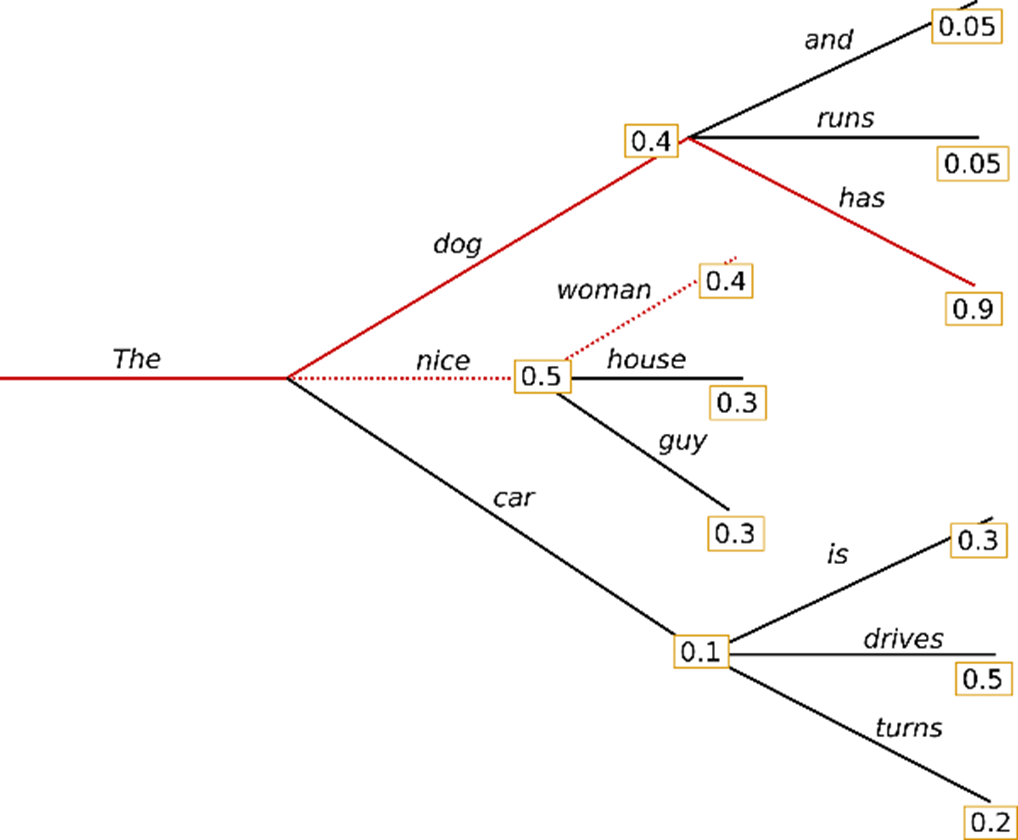

In [ ]:
from mindnlp.transformers import GPT2Tokenizer, GPT2LMHeadModel

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# add the EOS token as PAD token to avoid warnings
model = GPT2LMHeadModel.from_pretrained("gpt2", pad_token_id=tokenizer.eos_token_id)

# encode context the generation is conditioned on
input_ids = tokenizer.encode('I enjoy walking with my cute dog', return_tensors='ms')

# activate beam search and early_stopping
beam_output = model.generate(
    input_ids, 
    max_length=50, 
    num_beams=5, 
    early_stopping=True
)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(beam_output[0], skip_special_tokens=True))
print(100 * '-')

# set no_repeat_ngram_size to 2
beam_output = model.generate(
    input_ids, 
    max_length=50, 
    num_beams=5, 
    no_repeat_ngram_size=2, 
    early_stopping=True
)

print("Beam search with ngram, Output:\n" + 100 * '-')
print(tokenizer.decode(beam_output[0], skip_special_tokens=True))
print(100 * '-')

# set return_num_sequences > 1
beam_outputs = model.generate(
    input_ids, 
    max_length=50, 
    num_beams=5, 
    no_repeat_ngram_size=2, 
    num_return_sequences=5, 
    early_stopping=True
)

# now we have 3 output sequences
print("return_num_sequences, Output:\n" + 100 * '-')
for i, beam_output in enumerate(beam_outputs):
    print("{}: {}".format(i, tokenizer.decode(beam_output, skip_special_tokens=True)))
print(100 * '-')


__Beam search issues__
![image-3.png](./images/image-3.png)

缺点：1. 无法解决重复问题；2. 开放域生成效果差

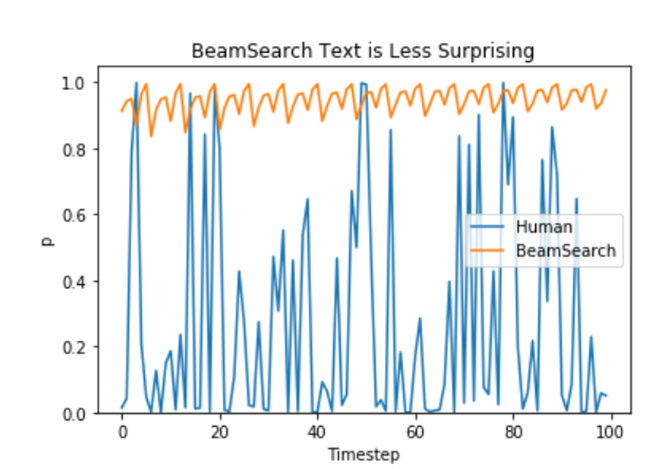

__Repeat problem__
![image-3-2.png](./images/image-3-2.png)

n-gram 惩罚:

将出现过的候选词的概率设置为 0

设置no_repeat_ngram_size=2 ，任意 2-gram 不会出现两次

Notice: 实际文本生成需要重复出现


__Sample__

根据当前条件概率分布随机选择输出词𝑤_𝑡 

![image-2.png](./images/image-2.png)

("car") ～P(w∣"The")
("drives") ～P(w∣"The","car")
![image-4.png](./images/image-4-2.png)

优点：文本生成多样性高

缺点：生成文本不连续

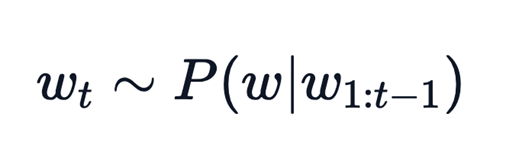
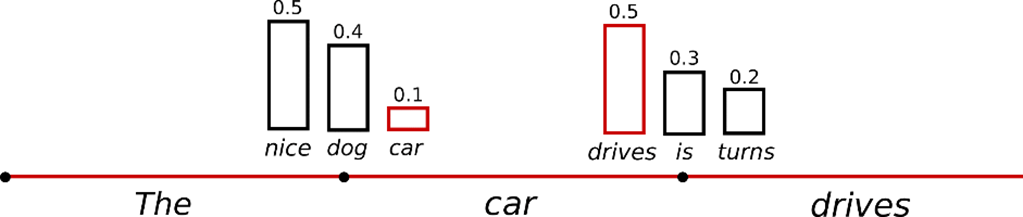

In [ ]:
import mindspore
from mindnlp.transformers import GPT2Tokenizer, GPT2LMHeadModel

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# add the EOS token as PAD token to avoid warnings
model = GPT2LMHeadModel.from_pretrained("gpt2", pad_token_id=tokenizer.eos_token_id)

# encode context the generation is conditioned on
input_ids = tokenizer.encode('I enjoy walking with my cute dog', return_tensors='ms')

mindspore.set_seed(0)
# activate sampling and deactivate top_k by setting top_k sampling to 0
sample_output = model.generate(
    input_ids, 
    do_sample=True, 
    max_length=50, 
    top_k=0
)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(sample_output[0], skip_special_tokens=True))

__Temperature__
降低softmax 的temperature使 P(w∣w1:t−1​)分布更陡峭

![image-3.png](./images/image-3-3.png)

增加高概率单词的似然并降低低概率单词的似然

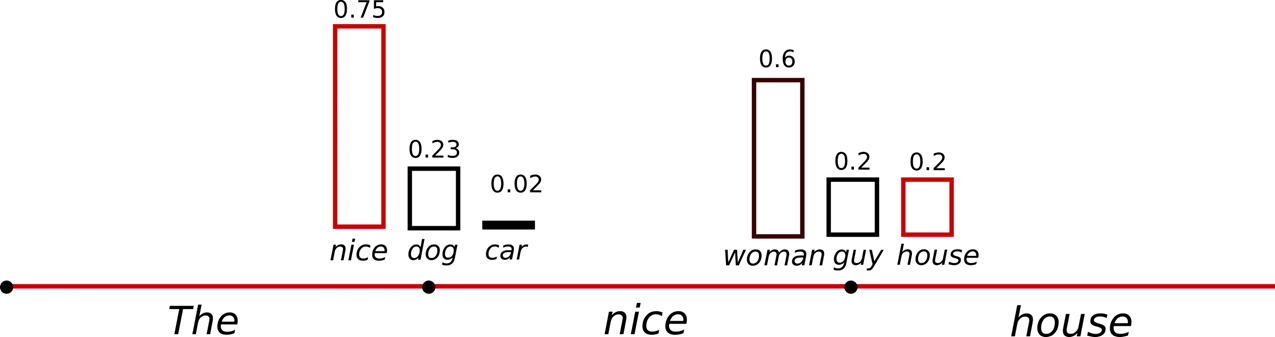

In [ ]:
import mindspore
from mindnlp.transformers import GPT2Tokenizer, GPT2LMHeadModel

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# add the EOS token as PAD token to avoid warnings
model = GPT2LMHeadModel.from_pretrained("gpt2", pad_token_id=tokenizer.eos_token_id)

# encode context the generation is conditioned on
input_ids = tokenizer.encode('I enjoy walking with my cute dog', return_tensors='ms')

mindspore.set_seed(1234)
# activate sampling and deactivate top_k by setting top_k sampling to 0
sample_output = model.generate(
    input_ids, 
    do_sample=True, 
    max_length=50, 
    top_k=0,
    temperature=0.7
)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(sample_output[0], skip_special_tokens=True))

__TopK sample__

选出概率最大的 K 个词，重新归一化，最后在归一化后的 K 个词中采样
![image.png](./images/images.png)

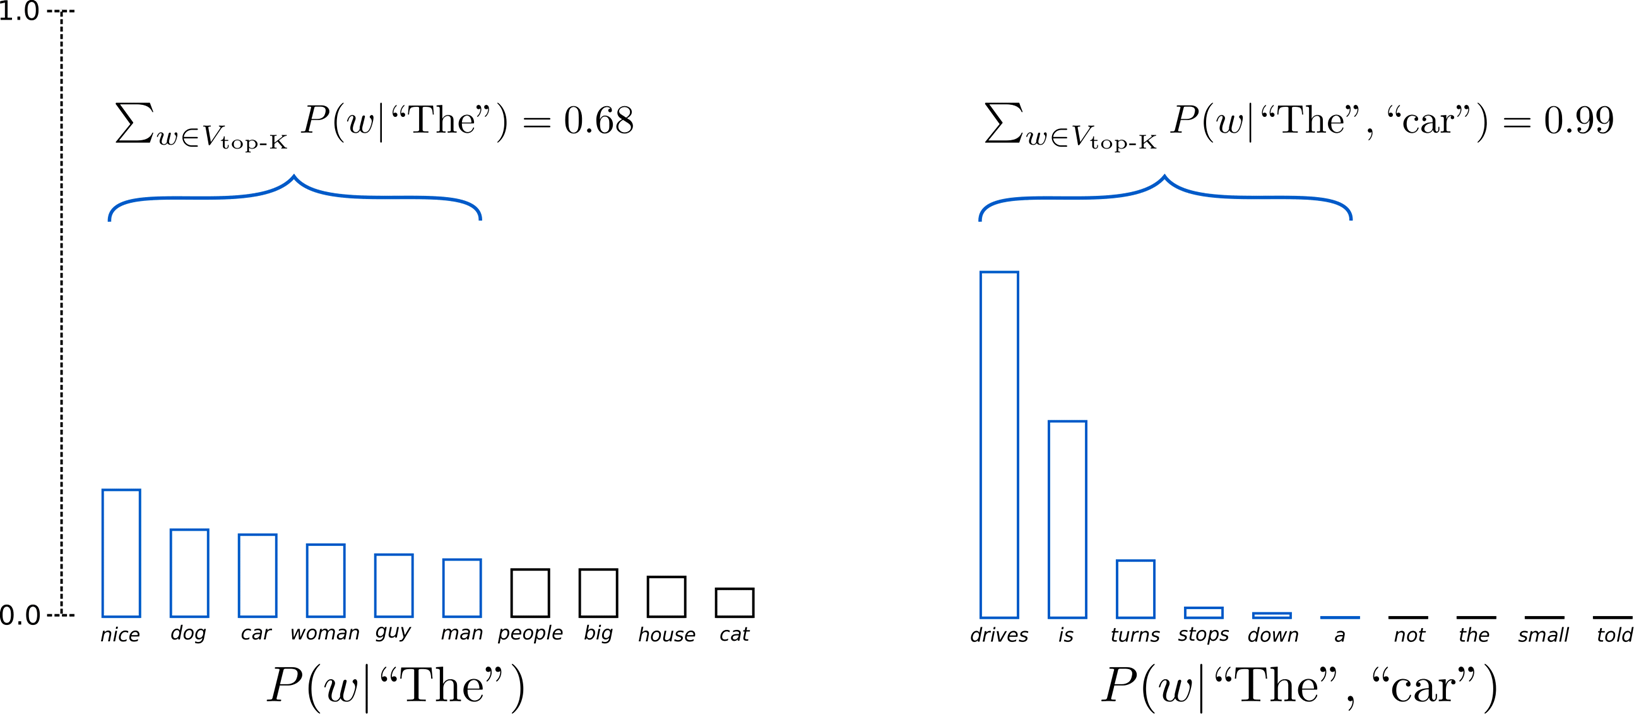

__TopK sample problems__

![image-2.png](./images/TopK_sample_problems.png)

将采样池限制为固定大小 K ：
* 在分布比较尖锐的时候产生胡言乱语
* 在分布比较平坦的时候限制模型的创造力

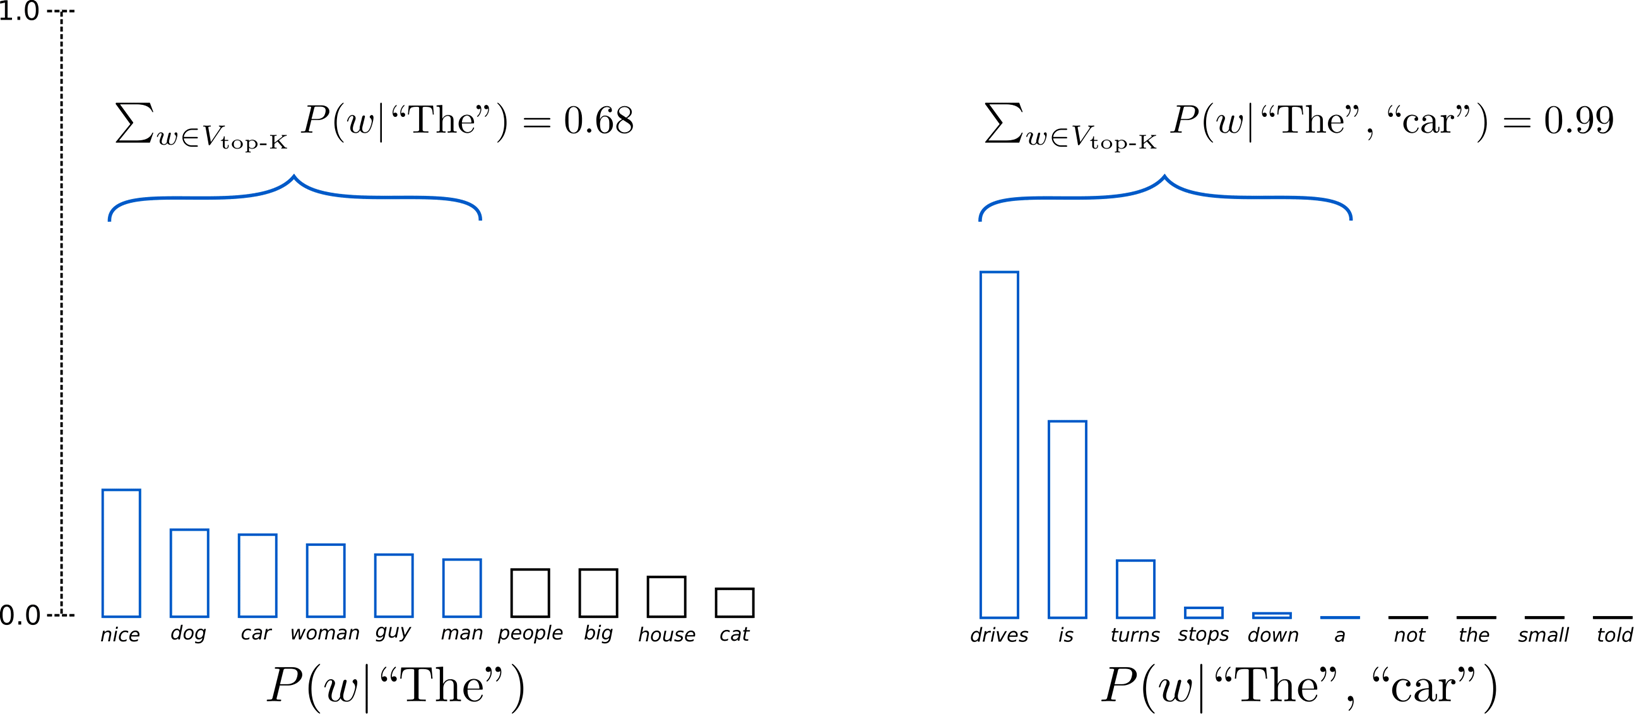

In [ ]:
import mindspore
from mindnlp.transformers import GPT2Tokenizer, GPT2LMHeadModel

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# add the EOS token as PAD token to avoid warnings
model = GPT2LMHeadModel.from_pretrained("gpt2", pad_token_id=tokenizer.eos_token_id)

# encode context the generation is conditioned on
input_ids = tokenizer.encode('I enjoy walking with my cute dog', return_tensors='ms')

mindspore.set_seed(0)
# activate sampling and deactivate top_k by setting top_k sampling to 0
sample_output = model.generate(
    input_ids, 
    do_sample=True, 
    max_length=50, 
    top_k=50
)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(sample_output[0], skip_special_tokens=True))

__Top-P sample__

在累积概率超过概率 p 的最小单词集中进行采样，重新归一化

![image-3.png](./images/Top-P_sample.png)

采样池可以根据下一个词的概率分布动态增加和减少

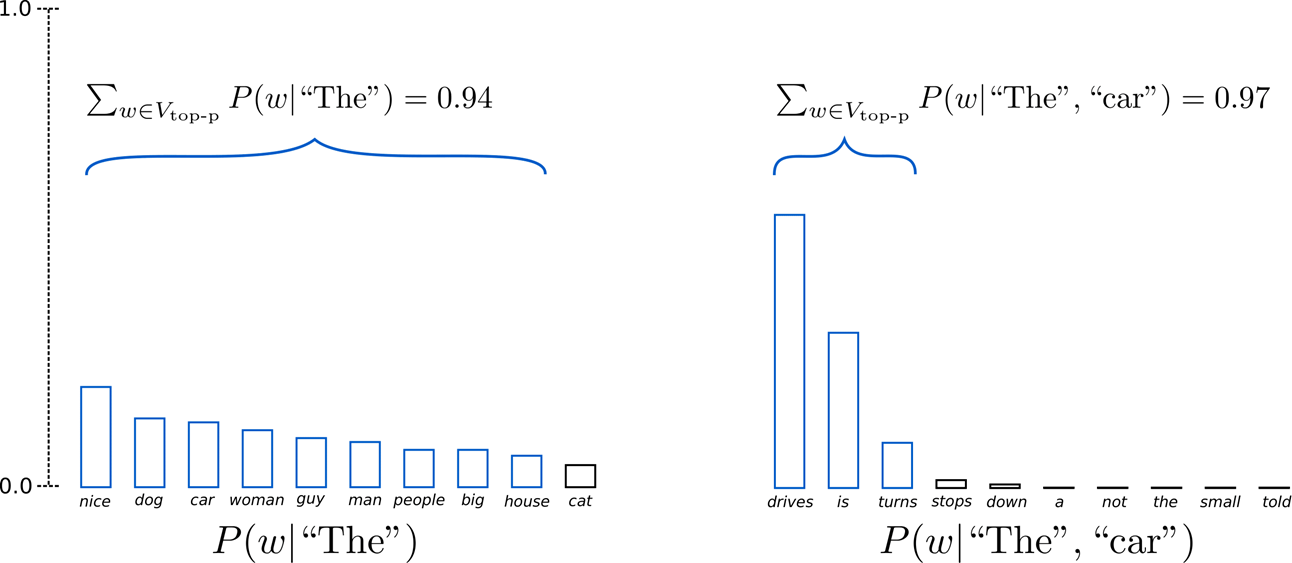

In [ ]:
import mindspore
from mindnlp.transformers import GPT2Tokenizer, GPT2LMHeadModel

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# add the EOS token as PAD token to avoid warnings
model = GPT2LMHeadModel.from_pretrained("gpt2", pad_token_id=tokenizer.eos_token_id)

# encode context the generation is conditioned on
input_ids = tokenizer.encode('I enjoy walking with my cute dog', return_tensors='ms')

mindspore.set_seed(0)

# deactivate top_k sampling and sample only from 92% most likely words
sample_output = model.generate(
    input_ids, 
    do_sample=True, 
    max_length=50, 
    top_p=0.92, 
    top_k=0
)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(sample_output[0], skip_special_tokens=True))

__top_k_top_p__

In [ ]:
import mindspore
from mindnlp.transformers import GPT2Tokenizer, GPT2LMHeadModel

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# add the EOS token as PAD token to avoid warnings
model = GPT2LMHeadModel.from_pretrained("gpt2", pad_token_id=tokenizer.eos_token_id)

# encode context the generation is conditioned on
input_ids = tokenizer.encode('I enjoy walking with my cute dog', return_tensors='ms')

mindspore.set_seed(0)
# set top_k = 50 and set top_p = 0.95 and num_return_sequences = 3
sample_outputs = model.generate(
    input_ids,
    do_sample=True,
    max_length=50,
    top_k=5,
    top_p=0.95,
    num_return_sequences=3
)

print("Output:\n" + 100 * '-')
for i, sample_output in enumerate(sample_outputs):
  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))